<a href="https://colab.research.google.com/github/internallylose/To-detect-the-fake-reviews-/blob/main/model_for_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
csv_file_path = '/content/drive/My Drive/data_cleaning_fake_reviews.csv'
df = pd.read_csv(csv_file_path)
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,love well made sturdi comfort i love veri pretti
1,Home_and_Kitchen_5,5,CG,love great upgrad origin i 've mine coupl year
2,Home_and_Kitchen_5,5,CG,thi pillow save back i love look feel pillow
3,Home_and_Kitchen_5,1,CG,miss inform use great product price i
4,Home_and_Kitchen_5,5,CG,veri nice set good qualiti we set two month


In [ ]:
df.dropna(inplace=True)
df['length'] = df['text_'].apply(len)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40431 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  40431 non-null  object
 1   rating    40431 non-null  int64 
 2   label     40431 non-null  object
 3   text_     40431 non-null  object
 4   length    40431 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.9+ MB


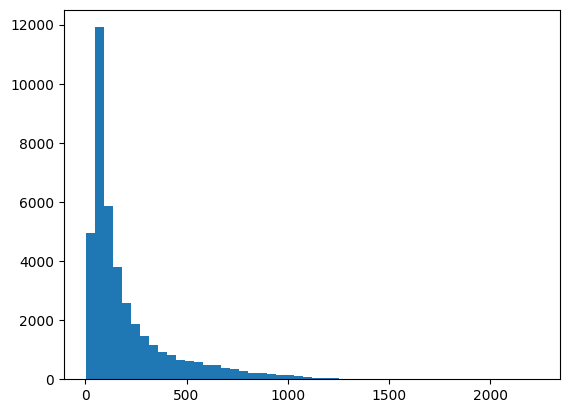

In [ ]:
plt.hist(df['length'],bins=50)
plt.show()

In [ ]:
df.groupby('label').describe()


rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20215.0  4.259906  1.141092  1.0  4.0  5.0  5.0  5.0  20215.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                 
             mean         std   min   25%    50%    75%     max  
label                                                            
CG     173.639030  173.955252  13.0  57.0   99.0  217.0  1300.0  
OR     237.889395  252.923293   4.0  74.0  134.0  296.0  2232.0

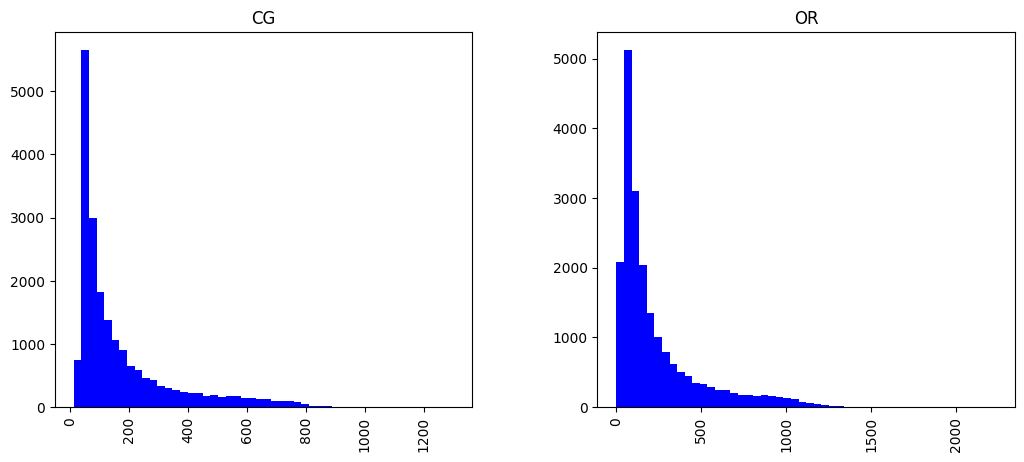

In [ ]:
df.hist(column='length',by='label',bins=50,color='blue',figsize=(12,5))
plt.show()

In [ ]:
df[df['label']=='OR'][['text_','length']].sort_values(by='length',ascending=False).head().iloc[0].text_

"weak on current scienc after see twice i agre much posit five star review out respect read review i 'll repeat everyth i like present i found goofi over ear hairdo facial hair arrang daniel vitali describ `` wild food expert '' distract ugh ditto david wolf extrem goofi wild hairdo on hand jon gabriel describ `` author weight loss expert '' nice groom good present hi stori person transform fellow pound whew becom jock normal weight inspir christian northrup preserv rank one america 's cutest doctor a realli nice look woman present dr. mercola jason vale kri carr alejandro junger fine it disappoint jami oliv popular uk give babi cow growth fluid pas unscientif popular idea milk none present anyth zilch say work doctor t. colin campbel milk bodi bad it good see present take stand sugar they agre evil sugar refin carbohydr with respect dr. northrup `` it 's fat make fat 's sugar '' statement pas muster commun expert recogn evil sugar not mutual exclus recogn proven danger fat particularl

In [ ]:
df.length.describe()

count    40431.000000
mean       205.765007
std        219.423370
min          4.000000
25%         64.000000
50%        116.000000
75%        253.000000
max       2232.000000
Name: length, dtype: float64

In [ ]:
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [ ]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x7bb15bb5db40>)

In [ ]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 34448


In [ ]:
review4 = df['text_'][3]
review4

'miss inform use great product price i'

In [ ]:
bow_msg4 = bow_transformer.transform([review4])
print(bow_msg4)
print(bow_msg4.shape)

  (0, 13596)	1
  (0, 15838)	1
  (0, 19846)	1
  (0, 23845)	1
  (0, 23975)	1
  (0, 32180)	1
(1, 34448)


In [ ]:
print(bow_transformer.get_feature_names_out()[15838])
print(bow_transformer.get_feature_names_out()[23845])

inform
price


In [ ]:
bow_reviews = bow_transformer.transform(df['text_'])


In [ ]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

Shape of Bag of Words Transformer for the entire reviews corpus: (40431, 34448)
Amount of non zero values in the bag of words model: 1013887


In [ ]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.07


In [ ]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_rev4 = tfidf_transformer.transform(bow_msg4)
print(bow_msg4)

  (0, 13596)	1
  (0, 15838)	1
  (0, 19846)	1
  (0, 23845)	1
  (0, 23975)	1
  (0, 32180)	1


In [ ]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['mango']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['book']])

10.91422964906803
2.821684385176731


In [ ]:
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40431, 34448)
No. of Dimensions: 2


In [ ]:
#Creating training and testing data
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.35)

In [ ]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [ ]:
#Training and testing Multinomial Naive Bayes Algorithm on the preprocessed data
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7bb15bb5db40>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [ ]:
predictions = pipeline.predict(review_test)
predictions

array(['CG', 'CG', 'CG', ..., 'OR', 'CG', 'CG'], dtype='<U2')

In [ ]:
print('Classification Report:',classification_report(label_test,predictions))
print('Confusion Matrix:',confusion_matrix(label_test,predictions))
print('Accuracy Score:',accuracy_score(label_test,predictions))

Classification Report:               precision    recall  f1-score   support

          CG       0.82      0.88      0.85      7090
          OR       0.87      0.81      0.84      7061

    accuracy                           0.85     14151
   macro avg       0.85      0.85      0.85     14151
weighted avg       0.85      0.85      0.85     14151

Confusion Matrix: [[6257  833]
 [1329 5732]]
Accuracy Score: 0.8472192777895555


In [ ]:
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,predictions)*100,2)) + '%')

Model Prediction Accuracy: 84.72%


In [ ]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

In [ ]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7bb15bb5db40>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [ ]:
rfc_pred = pipeline.predict(review_test)
rfc_pred

array(['CG', 'CG', 'CG', ..., 'OR', 'CG', 'CG'], dtype=object)

In [ ]:
print('Classification Report:',classification_report(label_test,rfc_pred))
print('Confusion Matrix:',confusion_matrix(label_test,rfc_pred))
print('Accuracy Score:',accuracy_score(label_test,rfc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,rfc_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.81      0.88      0.85      7090
          OR       0.87      0.79      0.83      7061

    accuracy                           0.84     14151
   macro avg       0.84      0.84      0.84     14151
weighted avg       0.84      0.84      0.84     14151

Confusion Matrix: [[6268  822]
 [1469 5592]]
Accuracy Score: 0.8381033142534097
Model Prediction Accuracy: 83.81%


In [ ]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',DecisionTreeClassifier())
])

In [ ]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7bb15bb5db40>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', DecisionTreeClassifier())])

In [ ]:
dtree_pred = pipeline.predict(review_test)
dtree_pred

array(['OR', 'CG', 'OR', ..., 'OR', 'CG', 'CG'], dtype=object)

In [ ]:
print('Classification Report:',classification_report(label_test,dtree_pred))
print('Confusion Matrix:',confusion_matrix(label_test,dtree_pred))
print('Accuracy Score:',accuracy_score(label_test,dtree_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.73      0.75      0.74      7090
          OR       0.74      0.72      0.73      7061

    accuracy                           0.74     14151
   macro avg       0.74      0.74      0.74     14151
weighted avg       0.74      0.74      0.74     14151

Confusion Matrix: [[5335 1755]
 [1950 5111]]
Accuracy Score: 0.7381810472758109
Model Prediction Accuracy: 73.82%


In [ ]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',KNeighborsClassifier(n_neighbors=2))
])

In [ ]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7bb15bb5db40>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', KNeighborsClassifier(n_neighbors=2))])

In [ ]:
knn_pred = pipeline.predict(review_test)
knn_pred

array(['CG', 'CG', 'CG', ..., 'CG', 'CG', 'CG'], dtype=object)

In [ ]:
print('Classification Report:',classification_report(label_test,knn_pred))
print('Confusion Matrix:',confusion_matrix(label_test,knn_pred))
print('Accuracy Score:',accuracy_score(label_test,knn_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,knn_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.54      0.97      0.70      7090
          OR       0.87      0.18      0.30      7061

    accuracy                           0.58     14151
   macro avg       0.71      0.58      0.50     14151
weighted avg       0.71      0.58      0.50     14151

Confusion Matrix: [[6896  194]
 [5778 1283]]
Accuracy Score: 0.5779803547452477
Model Prediction Accuracy: 57.8%


In [ ]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SVC())
])

In [ ]:
pipeline.fit(review_train,label_train)


Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7bb15bb5db40>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [ ]:
svc_pred = pipeline.predict(review_test)
svc_pred

array(['OR', 'CG', 'CG', ..., 'OR', 'CG', 'CG'], dtype=object)

In [ ]:
print('Classification Report:',classification_report(label_test,svc_pred))
print('Confusion Matrix:',confusion_matrix(label_test,svc_pred))
print('Accuracy Score:',accuracy_score(label_test,svc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.90      0.86      0.88      7090
          OR       0.87      0.90      0.88      7061

    accuracy                           0.88     14151
   macro avg       0.88      0.88      0.88     14151
weighted avg       0.88      0.88      0.88     14151

Confusion Matrix: [[6123  967]
 [ 703 6358]]
Accuracy Score: 0.8819871387181117
Model Prediction Accuracy: 88.2%


In [ ]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',LogisticRegression())
])

In [ ]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7bb15bb5db40>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

In [ ]:
lr_pred = pipeline.predict(review_test)
lr_pred

array(['OR', 'CG', 'CG', ..., 'OR', 'CG', 'CG'], dtype=object)

In [ ]:
print('Classification Report:',classification_report(label_test,lr_pred))
print('Confusion Matrix:',confusion_matrix(label_test,lr_pred))
print('Accuracy Score:',accuracy_score(label_test,lr_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.88      0.85      0.86      7090
          OR       0.85      0.88      0.87      7061

    accuracy                           0.86     14151
   macro avg       0.86      0.86      0.86     14151
weighted avg       0.86      0.86      0.86     14151

Confusion Matrix: [[6015 1075]
 [ 850 6211]]
Accuracy Score: 0.8639672107978235
Model Prediction Accuracy: 86.4%


In [ ]:
print('Performance of various ML models:')
print('\n')
print('Logistic Regression Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_pred)*100,2)) + '%')
print('K Nearest Neighbors Prediction Accuracy:',str(np.round(accuracy_score(label_test,knn_pred)*100,2)) + '%')
print('Decision Tree Classifier Prediction Accuracy:',str(np.round(accuracy_score(label_test,dtree_pred)*100,2)) + '%')
print('Random Forests Classifier Prediction Accuracy:',str(np.round(accuracy_score(label_test,rfc_pred)*100,2)) + '%')
print('Support Vector Machines Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')
print('Multinomial Naive Bayes Prediction Accuracy:',str(np.round(accuracy_score(label_test,predictions)*100,2)) + '%')

Performance of various ML models:


Logistic Regression Prediction Accuracy: 86.4%
K Nearest Neighbors Prediction Accuracy: 57.8%
Decision Tree Classifier Prediction Accuracy: 73.82%
Random Forests Classifier Prediction Accuracy: 83.81%
Support Vector Machines Prediction Accuracy: 88.2%
Multinomial Naive Bayes Prediction Accuracy: 84.72%
